# Grad-CAM

This notebook implements the Grad-CAM algorithm used in interpretability of Convolutional Networks:

Let $A^l$ be the activation signal of the last spacial layer $l$ in the network,
$$
L = upsample(\partial J/A^l_i,j \odot A^l)
$$

References:

  - https://arxiv.org/pdf/1908.04351.pdf

In [1]:
LAST_SPACIAL_LAYER = 'block14_sepconv2_act'

REPETITIONS = 50
NOISE = 0.2

## Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

! cp -r '/content/drive/MyDrive/Colab Notebooks/cs-no/6.grads/config' .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
from config import config, data, model, utils

from config.utils import to_image, normalize, standardize

utils.setup_clean_image_plotting()

In [4]:
from tensorflow.python.keras.applications import xception

config.model.architecture = tf.keras.applications.Xception
config.model.module = xception
config.model.decode = tf.keras.applications.xception.decode_predictions
config.model.preprocess = tf.keras.applications.xception.preprocess_input
config.model.decompress = lambda x: (x + 1.) * 127.5

config.data.image_size = (299, 299)
config.data.input_shape = (config.data.batch_size, 299, 299, 3)

In [5]:
images = data.load_images()
x = model.preprocess(images)

In [6]:
nn = model.build()

logits = nn(x, training=False)
preds = tf.argmax(logits, axis=1)
probs = tf.nn.softmax(logits)
decoded = model.decode(probs.numpy(), top=2)

In [7]:
nn_s = tf.keras.Model(
    inputs=nn.inputs,
    outputs=[nn.output, nn.get_layer(LAST_SPACIAL_LAYER).output],
    name='model_spacial')

## Vanilla

In [8]:
def activation_loss(y, units):
    return tf.gather(y, units, axis=1, batch_dims=1)

@tf.function
def gradcam(inputs, units):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(inputs)
        y, z = nn_s(inputs, training=False)
        loss = activation_loss(y, units)

    dldx, grads = tape.gradient(loss, [inputs, z], unconnected_gradients=tf.UnconnectedGradients.ZERO)
    weights = tf.reduce_mean(grads, axis=(1, 2), keepdims=True)
    maps = tf.reduce_mean(z*weights, axis=-1, keepdims=True)

    # We are not concerned with pixels that negatively contribute
    # to its classification, only pixels that belong to that class.
    maps = tf.nn.relu(maps)
    maps = standardize(maps)
    maps = tf.map_fn(lambda i: tf.image.resize(i, config.data.image_size), maps)

    return loss, dldx, maps

In [9]:
loss, grads, maps = gradcam(x, preds)

gs = tf.reduce_sum(tf.abs(grads), axis=-1)
gs = standardize(gs)

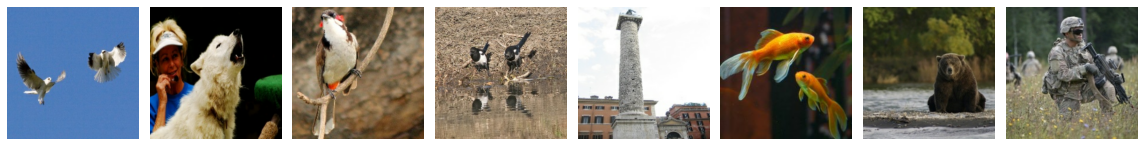

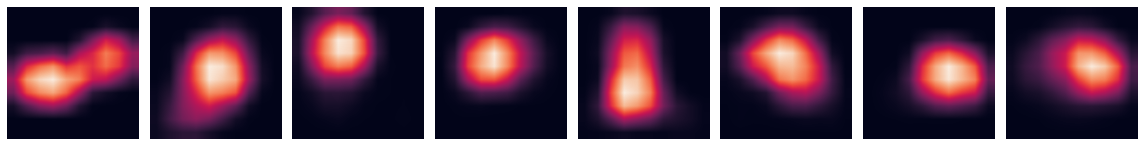

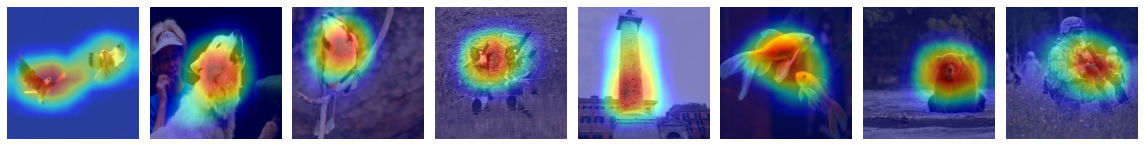

In [10]:
#@title

utils.plot(to_image(images[:8]))
utils.plot(maps[:8, ..., 0].numpy())
utils.plot_heatmaps(to_image(images[:8]), maps[:8, ..., 0].numpy())

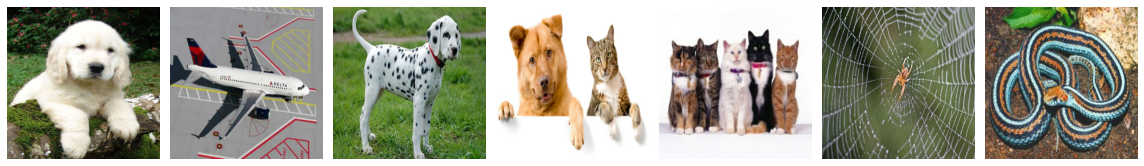

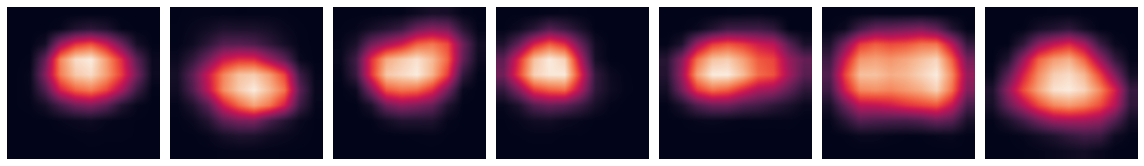

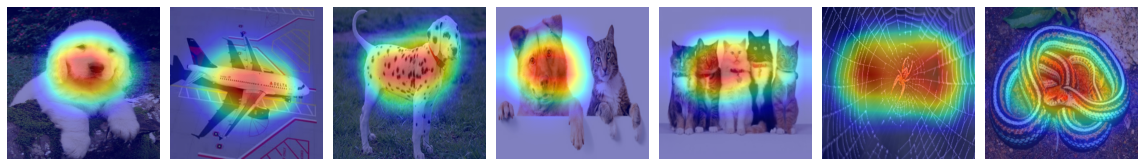

In [11]:
#@title

utils.plot(to_image(images[8:]))
utils.plot(maps[8:, ..., 0].numpy())
utils.plot_heatmaps(to_image(images[8:]), maps[8:, ..., 0].numpy())

## Smooth Grad

In [12]:
@tf.function
def smooth_gradients(inputs, units, num_samples=20, noise=.2):
    x = tf.repeat(inputs, num_samples, axis=0)
    x += tf.random.normal(x.shape, mean=0, stddev=noise/2)
    
    y = tf.repeat(units, num_samples)
    loss, grads, maps = gradcam(x, y)

    grads = tf.reshape(grads, (-1, num_samples, *grads.shape[1:]))
    maps = tf.reshape(maps, (-1, num_samples, *maps.shape[1:]))

    # We are not concerned with pixels that negatively contribute
    # to its classification, only pixels that belong to that class.
    maps = tf.reduce_mean(maps, axis=1)

    maps = tf.nn.relu(maps)
    maps = standardize(maps)
    maps = tf.map_fn(lambda i: tf.image.resize(i, config.data.image_size), maps)

    return loss, tf.reduce_mean(grads, axis=1), maps

In [13]:
# One image at a time to avoid performance issues with larger models.
r = [smooth_gradients(x[i:i+1], preds[i:i+1],
                      REPETITIONS,
                      NOISE)
     for i in range(len(images))]

loss, grads, maps = (tf.concat(t, axis=0) for t in zip(*r))

In [14]:
# Absolute gradients weighted CAM
gs = tf.abs(grads)
gs = standardize(gs)

gm = tf.reduce_sum(gs * maps, axis=-1, keepdims=True)
gm = normalize(gm)

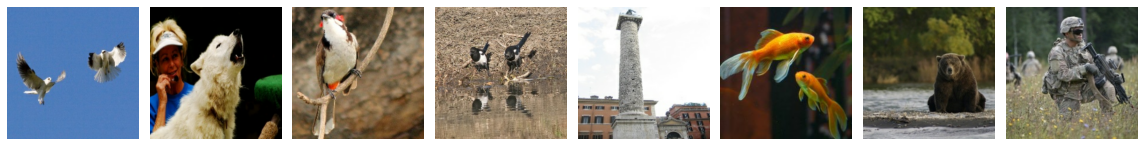

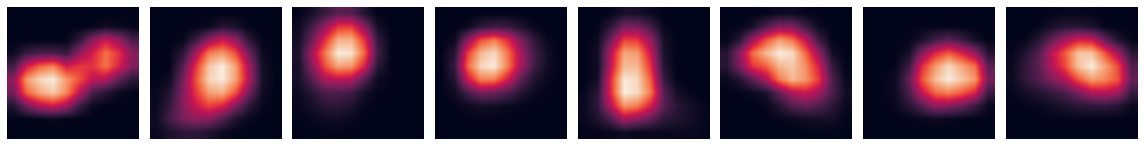

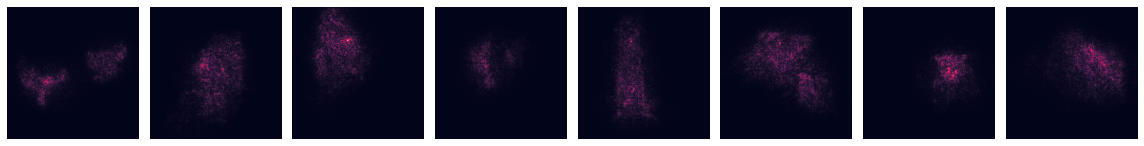

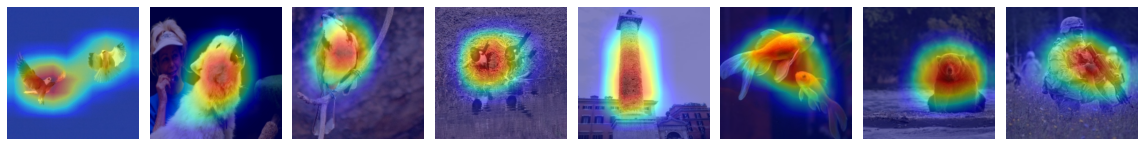

In [15]:
#@title

utils.plot(to_image(images[:8]))
utils.plot(maps[:8, ..., 0].numpy())
utils.plot(gm[:8, ..., 0].numpy())
utils.plot_heatmaps(to_image(images[:8]), maps[:8, ..., 0].numpy())

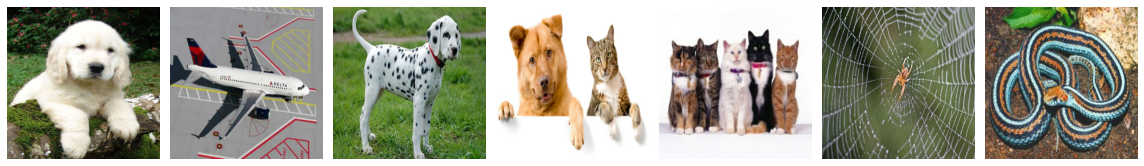

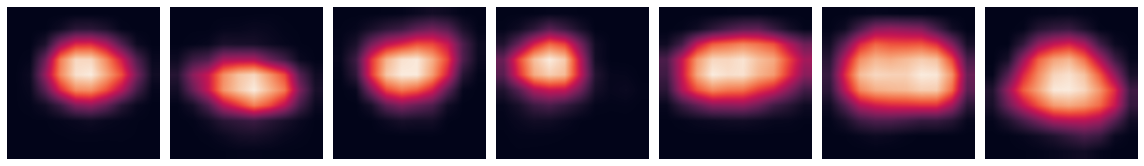

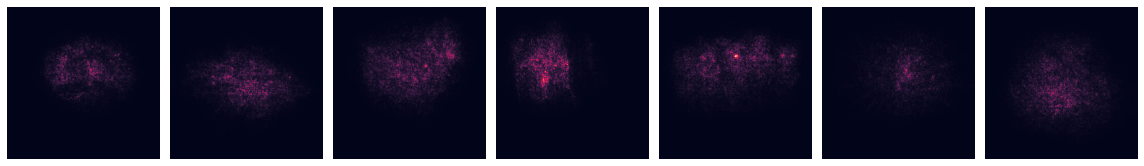

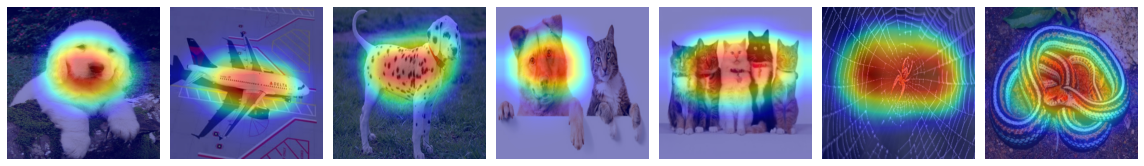

In [17]:
#@title

utils.plot(to_image(images[8:]))
utils.plot(maps[8:, ..., 0].numpy())
utils.plot(gm[8:, ..., 0].numpy())
utils.plot_heatmaps(to_image(images[8:]), maps[8:, ..., 0].numpy())

## Guided Grad-CAM

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.python.keras.layers import VersionAwareLayers

@tf.custom_gradient
def guided_relu(x, max_value=None):
  def grad(dy):
    f = dy > 0
    r = x > 0
    if max_value is not None: r &= x <= max_value
    return dy * tf.cast(f & r, dy.dtype)

  x = tf.nn.relu(x)

  if max_value is not None:
    zero = tf.constant(0, tf.float32)
    x = tf.clip_by_value(x, zero, max_value)

  return x, grad


class GuidedReLU(tf.keras.layers.ReLU):
  def call(self, inputs):
    return guided_relu(inputs, self.max_value)

layers = VersionAwareLayers()
layers.ReLU = GuidedReLU

In [19]:
for l in nn.layers:
    if hasattr(l, 'activation') and l.activation is tf.keras.activations.relu:
        l.activation = guided_relu

In [25]:
logits = nn(x, training=False)
preds = tf.argmax(logits, axis=1)
probs = tf.nn.softmax(logits)
decoded = model.decode(probs.numpy(), top=2)

In [27]:
nn_s = tf.keras.Model(
    inputs=nn.inputs,
    outputs=[nn.output, nn.get_layer(LAST_SPACIAL_LAYER).output],
    name='model_spacial')

In [28]:
def activation_loss(y, units):
    return tf.gather(y, units, axis=1, batch_dims=1)

@tf.function
def gradcam(inputs, units):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(inputs)
        y, z = nn_s(inputs, training=False)
        loss = activation_loss(y, units)

    dldx, grads = tape.gradient(loss, [inputs, z], unconnected_gradients=tf.UnconnectedGradients.ZERO)
    weights = tf.reduce_mean(grads, axis=(1, 2), keepdims=True)
    maps = tf.reduce_mean(z*weights, axis=-1, keepdims=True)

    # We are not concerned with pixels that negatively contribute
    # to its classification, only pixels that belong to that class.
    maps = tf.nn.relu(maps)
    maps = standardize(maps)
    maps = tf.map_fn(lambda i: tf.image.resize(i, config.data.image_size), maps)

    return loss, dldx, maps

In [29]:
@tf.function
def smooth_gradients(inputs, units, num_samples=20, noise=.2):
    x = tf.repeat(inputs, num_samples, axis=0)
    x += tf.random.normal(x.shape, mean=0, stddev=noise/2)
    
    y = tf.repeat(units, num_samples)
    loss, grads, maps = gradcam(x, y)

    grads = tf.reshape(grads, (-1, num_samples, *grads.shape[1:]))
    maps = tf.reshape(maps, (-1, num_samples, *maps.shape[1:]))

    # We are not concerned with pixels that negatively contribute
    # to its classification, only pixels that belong to that class.
    maps = tf.reduce_mean(maps, axis=1)

    maps = tf.nn.relu(maps)
    maps = standardize(maps)
    maps = tf.map_fn(lambda i: tf.image.resize(i, config.data.image_size), maps)

    return loss, tf.reduce_mean(grads, axis=1), maps

In [30]:
# One image at a time to avoid performance issues with larger models.
r = [smooth_gradients(x[i:i+1], preds[i:i+1],
                      REPETITIONS,
                      NOISE)
     for i in range(len(images))]

loss, grads, maps = (tf.concat(t, axis=0) for t in zip(*r))

In [31]:
# Absolute gradients weighted CAM
gs = tf.abs(grads)
gs = standardize(gs)

gm = tf.reduce_sum(gs * maps, axis=-1, keepdims=True)
gm = normalize(gm)

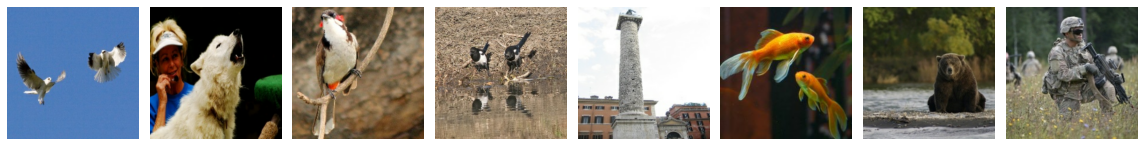

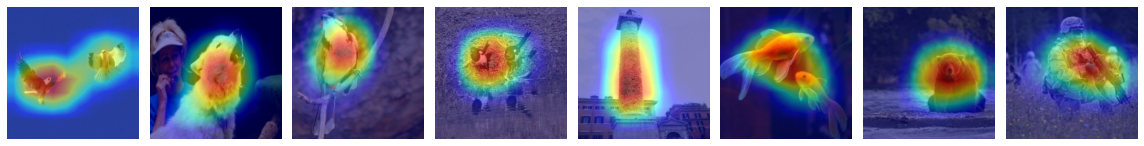

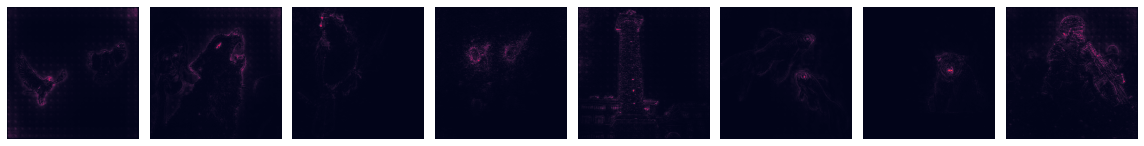

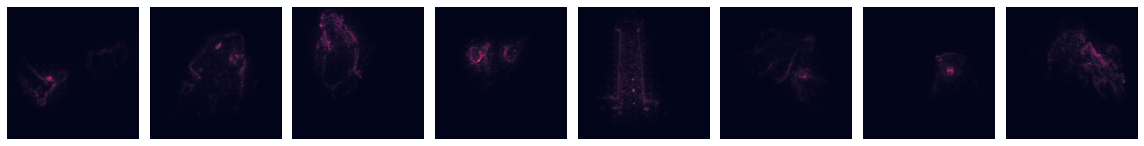

In [34]:
#@title

utils.plot(to_image(images[:8]))
utils.plot_heatmaps(to_image(images[:8]), maps[:8, ..., 0].numpy())
utils.plot(gs[:8, ..., 0].numpy())
utils.plot(gm[:8, ..., 0].numpy())

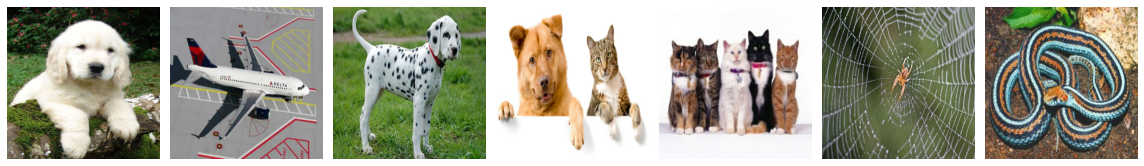

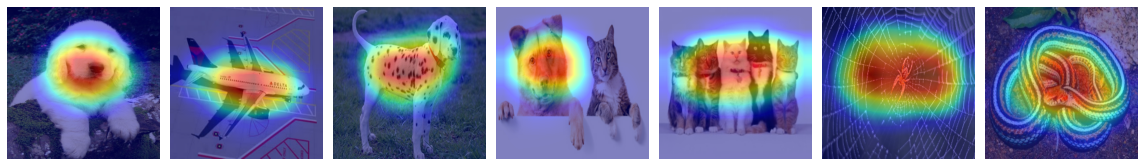

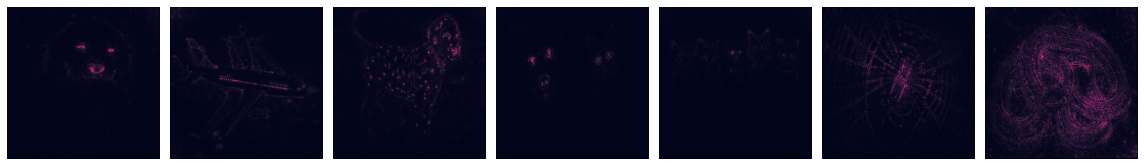

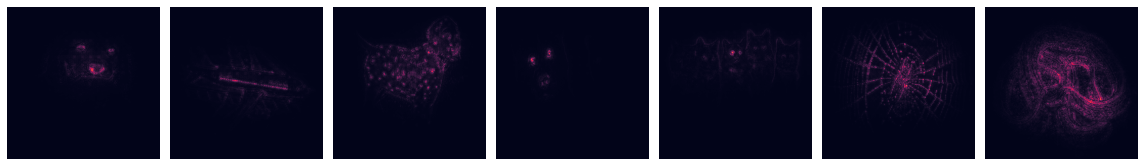

In [35]:
#@title

utils.plot(to_image(images[8:]))
utils.plot_heatmaps(to_image(images[8:]), maps[8:, ..., 0].numpy())
utils.plot(gs[8:, ..., 0].numpy())
utils.plot(gm[8:, ..., 0].numpy())